## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [1]:
!wget https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip
!unzip -qq data.zip

--2021-12-21 20:40:00--  https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.18, 2620:100:6024:18::a27d:4412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/vgqpz2f1lolxmlv/data.zip [following]
--2021-12-21 20:40:00--  https://www.dropbox.com/s/raw/vgqpz2f1lolxmlv/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc9ced848c9ea6602703a6bbf3c.dl.dropboxusercontent.com/cd/0/inline/BcTaHyfVj99B5j-B7yb_zrUIaIXdIQdnIVvEBgdhoCCbWh3euPt0rgYMnzSoyaB6WB1k1_VnUxbSYhultpm7wTi1rOk5vho2BfEuwvykG2N60D5qTHithGIcB2dHBdA-pYS5k9y9mmoLdlURSIQT-pSn/file# [following]
--2021-12-21 20:40:01--  https://ucc9ced848c9ea6602703a6bbf3c.dl.dropboxusercontent.com/cd/0/inline/BcTaHyfVj99B5j-B7yb_zrUIaIXdIQdnIVvEBgdhoCCbWh3euPt0rgYMnzSoyaB6WB1k1_VnUxbSYhultpm7wTi1rOk5vho2BfE

In [2]:
import torch
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
from collections import defaultdict
from tqdm.auto import tqdm
from IPython.display import clear_output
from PIL import Image
import copy
import time
import os

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
DATA_PATH = r"data"
NUM_WORKERS = 2
SIZE_H = SIZE_W = 96
NUM_CLASSES = 50
EPOCH_NUM = 30
BATCH_SIZE = 256
EMBEDDING_SIZE = 128

image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

In [4]:
os.mkdir("data/val")
for i in range(50):
  os.mkdir(f'data/val/{i}')
  for j in range(20):
    os.replace(f'data/train/{i}/{j}.jpeg', f'data/val/{i}/{j}.jpeg')

In [5]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)
])

In [6]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train'), transform=transformer)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer)

In [7]:
n_train, n_val = len(train_dataset), len(val_dataset)
dataset_sizes = dict()
dataset_sizes['train'] = n_train
dataset_sizes['val'] = n_val
print(f'Train: {n_train}, val: {n_val}')

Train: 6166, val: 1000


In [8]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=BATCH_SIZE,
                                            num_workers=NUM_WORKERS)

dataloaders = dict()
dataloaders['val'] = val_batch_gen
dataloaders['train'] = train_batch_gen

In [9]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = batch_gen.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)
        
        sample_title = 'Label = %s' % (class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

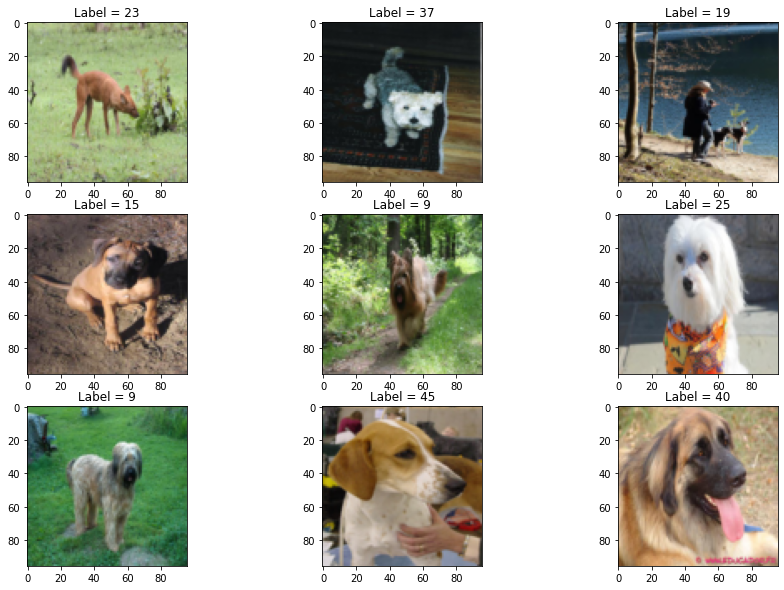

In [10]:
plot_from_batch_generator(train_batch_gen)

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_history = []
    val_acc_history = []
    train_acc_history = []

    for epoch in range(num_epochs):

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
   
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]


            if phase == 'val':
                loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            else:
                train_acc_history.append(epoch_acc)

        clear_output(True)
        
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'{phase} loss: {epoch_loss:.4f}, val_acc: {val_acc_history[-1]:.4f}, train_acc: {train_acc_history[-1]:.4f}')
        
        plt.figure(figsize=(12, 6))

        plt.subplot(121)
        plt.plot(loss_history)
        plt.title('Train loss')
        
        plt.subplot(122)
        plt.plot(val_acc_history, label='val')
        plt.plot(train_acc_history, label='train')
        plt.title('Accuracy')
        plt.legend()

        plt.show()

    finish_time = time.time() - start_time
    print(f'Training complete in {finish_time // 60:.0f}m {finish_time % 60:.0f}s')
    print(f'Best val accuracy: {best_acc:4f}')

    model.load_state_dict(best_model_wts)

    return model

In [12]:
model_resnet = torchvision.models.resnet18(pretrained=True)
#for param in model_resnet.parameters():
#    param.requires_grad = False

num_feat = model_resnet.fc.in_features
model_resnet.fc = nn.Sequential(
    nn.Linear(num_feat, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),    
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),     
    nn.Linear(512, 50),
)
model_resnet = model_resnet.to(device)

summary(model_resnet, (3, SIZE_H, SIZE_W))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]           4,096
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]          16,384
      BatchNorm2d-12          [-1, 256, 24, 24]             512
           Conv2d-13          [-1, 256, 24, 24]          16,384
      BatchNorm2d-14          [-1, 256,

In [13]:
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_resnet.parameters(), lr=1e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

Epoch 10/10
val loss: 1.2658, val_acc: 0.6910, train_acc: 0.9992


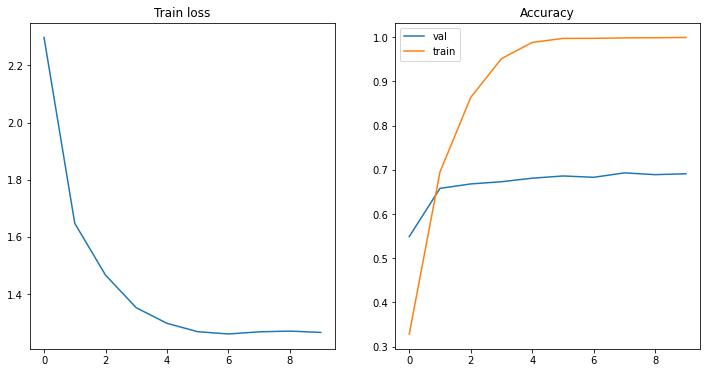

Training complete in 6m 57s
Best val accuracy: 0.693000


In [14]:
model = train_model(model_resnet, criterion, opt, exp_lr_scheduler, num_epochs=10)

In [15]:
result = []

class_names = train_batch_gen.dataset.classes

for test_image in os.listdir(DATA_PATH + '/test'):
  img = Image.open(DATA_PATH + '/test/' + test_image)
  input = transformer(img).reshape(1, 3, 96, 96).to(device)
  outputs = model(input)
  _, preds = torch.max(outputs, 1)

  result.append([test_image, class_names[preds.cpu().numpy()[0]]])                 

df = pd.DataFrame(result, columns = ['filename', 'class'])
df.to_csv('result.csv')

In [16]:
df

,filename,class
0,60.jpeg,33
1,314.jpeg,48
2,527.jpeg,35
3,1208.jpeg,18
4,674.jpeg,3
...,...,...
1498,887.jpeg,45
1499,1486.jpeg,23
1500,545.jpeg,34
1501,603.jpeg,10


Краткий отчет по экспериментам:
- Пробовались resnet18, resnet50, resnet101, resnet152. Была выбрана resnet50 из соотношения качество/скорость работы
- Обычного выходного слоя на 50 нейронов не хватило для получения высокого качества. Были добавлены 3 линейных слоя с ReLU и BatchNorm. Это помогает избежать переобучения и вписывается в архитектуру сети Resnet
- Был опробован вариант с заморозкой предобученной модели. В таком случае обучние происходило быстрее, но качество не поднималось выше 40%. Поэтому веса предобученной модели тоже обучались (скорее слегка корректировались под задачу)
- SGD в данной работе показал себя слишком плохо, намного хуже чем Adam
- Низкий learning rate сильно повлиял в лучшую сторону на качество обучения

При выполнении задания использовал материалы с гитхаба курса и с документации Pytorch (https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)